In [1]:
import pandas as pd
import polars as pl
from humanfriendly import format_size, format_number
from simpler_mpl import set_commas, set_common_mpl_styles
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

%load_ext autoreload
%autoreload 2

display(f"Pandas {pd.__version__}, Polars {pl.__version__}")

from cell_profiler import cell_profiler as cp
%start_cell_profiler

def show_rows_memory(df, deep=False):
    """
    Show rows and memory cost of a Pandas/Polars dataframe
    `deep=True` only has an impact on Pandas numpy-backed string columns, which otherwise are undercounted
    """
    num_bytes = 0
    df_type = 'Unknown'
    try:
        num_bytes = df.estimated_size() # try Polars
        df_type = 'Polars'
    except AttributeError:
        pass
    try:
        num_bytes = df.memory_usage(deep=deep, index=False).sum() # try Pandas
        df_type = 'Pandas'
    except AttributeError:
        pass
    display(f"{df_type} df with {format_number(df.shape[0])} rows, {format_size(num_bytes)} bytes")

'Pandas 2.0.1, Polars 0.17.10'

In [1] used 0.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 207.4 MiB


In [2]:
dfple = pl.read_parquet('../test_result_2021on.parquet')

In [2] used 12770.3 MiB RAM in 3.91s (system mean cpu 43%, single max cpu 55%), peaked 0.0 MiB above final usage, current RAM usage now 12977.7 MiB


In [3]:
show_rows_memory(dfple)

'Polars df with 82,012,245 rows, 11.14 GB bytes'

In [3] used 0.0 MiB RAM in 0.13s (system mean cpu 7%, single max cpu 31%), peaked 0.0 MiB above final usage, current RAM usage now 12977.7 MiB


In [4]:
dfple.schema

{'test_id': Int64,
 'vehicle_id': Int64,
 'test_date': Datetime(time_unit='ns', time_zone=None),
 'test_class_id': Int64,
 'test_type': Utf8,
 'test_result': Utf8,
 'test_mileage': Int64,
 'postcode_area': Utf8,
 'make': Utf8,
 'model': Utf8,
 'colour': Utf8,
 'fuel_type': Utf8,
 'cylinder_capacity': Int64,
 'first_use_date': Datetime(time_unit='ns', time_zone=None)}

In [4] used 0.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 12977.7 MiB


# Speed test

In [5]:
%timeit dfple['make'].str.n_chars()

1.23 s ± 37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
In [5] used 181.0 MiB RAM in 9.95s (system mean cpu 11%, single max cpu 100%), peaked 312.8 MiB above final usage, current RAM usage now 13158.7 MiB


In [6]:
%timeit dfple['test_class_id'].max()

48.2 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
In [6] used 0.0 MiB RAM in 4.02s (system mean cpu 9%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 13158.7 MiB


In [7]:
import numpy as np
np.testing.assert_approx_equal(74115.13152002622, dfple['test_mileage'].mean())

In [7] used 0.1 MiB RAM in 0.16s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 13158.8 MiB


In [8]:
%timeit dfple['test_mileage'].mean()

65.4 ms ± 1.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
In [8] used 0.0 MiB RAM in 5.39s (system mean cpu 10%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 13158.8 MiB


# Mileage vs first use year

In [9]:
#dfs_allfuel.shape

In [9] used 0.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 13158.8 MiB


In [10]:
%time dfple.filter(pl.col('test_result')=='P');

CPU times: user 21.7 s, sys: 24.4 s, total: 46.1 s
Wall time: 5.84 s
In [10] used 2678.4 MiB RAM in 6.48s (system mean cpu 57%, single max cpu 100%), peaked 10006.9 MiB above final usage, current RAM usage now 15837.2 MiB


In [11]:
#df_fuel = dfple.filter(pl.col('test_result')=='P').sample(10_000). \
#            with_columns(pl.col('first_use_date').dt.year().alias('first_use_year')). \
#            filter(((pl.col('fuel_type') == "PE")) | (pl.col('fuel_type') == 'DI')) \
#            [['test_mileage', 'first_use_year', 'fuel_type']]

In [11] used 0.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 15837.2 MiB


In [12]:
df_fuel = dfple.filter(pl.col('test_result')=='P').sample(10_000). \
            with_columns(pl.col('first_use_date').dt.year().alias('first_use_year')). \
            filter((pl.col('fuel_type').is_in({'PE', 'DI'}))) \
            [['test_mileage', 'first_use_year', 'fuel_type']]

In [12] used -94.9 MiB RAM in 6.02s (system mean cpu 64%, single max cpu 100%), peaked 11298.4 MiB above final usage, current RAM usage now 15742.3 MiB


In [13]:
#dfs_allfuel = dfple.filter(pl.col('test_result')=='P').sample(10_000)
#dfs_allfuel = dfs_allfuel.with_columns(pl.col('first_use_date').dt.year().alias('first_use_year'))
#dfs = dfs_allfuel.filter((pl.col('fuel_type') == "PE"))[['test_mileage', 'first_use_year', 'fuel_type']]
if False:
    # kde single for e.g. just petrol
    fig, ax = plt.subplots(constrained_layout=True, figsize=(4, 4))
    # cmap="Reds"
    #sns.kdeplot(x=dfs['first_use_year'], y=dfs['test_mileage'], ax=ax, fill=True, bw_adjust=.3)
    sns.kdeplot(x=dfs['first_use_year'], y=dfs['test_mileage'], ax=ax, fill=True, thresh=0.01)
    ax.set_xlim(xmin=1960)
    ax.set_ylim(ymax=400000)
    set_commas(ax, y_axis=True)
    set_common_mpl_styles(ax, ymin=-2000, title="MOT Year 2021+")

In [13] used 0.0 MiB RAM in 0.10s (system mean cpu 7%, single max cpu 20%), peaked 0.0 MiB above final usage, current RAM usage now 15742.3 MiB


/home/ian/miniconda3/envs/pydatalondon2023/lib/python3.11/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'hist_order'
  cset = contour_func(


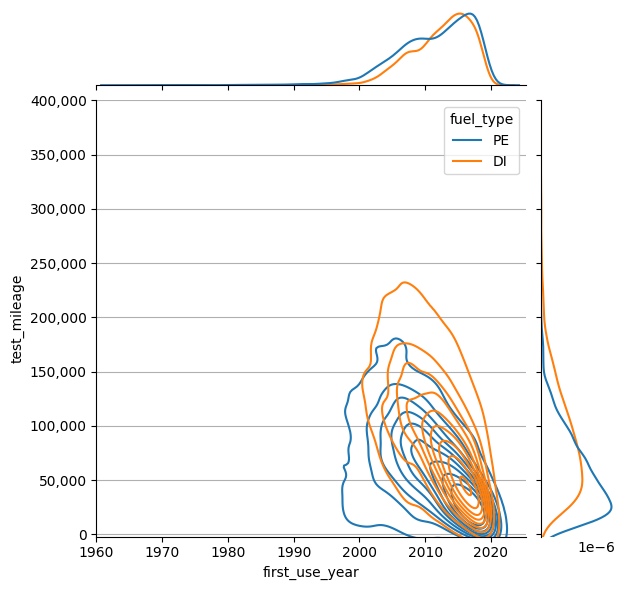

In [14] used 19.5 MiB RAM in 6.49s (system mean cpu 10%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 15761.8 MiB


In [14]:
#fig, ax = plt.subplots(constrained_layout=True, figsize=(4, 4))
jg = sns.jointplot(x=df_fuel['first_use_year'], y=df_fuel['test_mileage'], hue=df_fuel['fuel_type'], kind='kde', hist_order=['DI', 'PE']) 
# {x, y}lim can be set
# kind kde hist
jg.ax_joint.set_xlim(xmin=1960)
jg.ax_joint.set_ylim(ymax=400000)
set_commas(jg.ax_joint, y_axis=True)
set_common_mpl_styles(jg.ax_joint, ymin=-2000) # , title="MOT Year 2021+") title renders badly
#jg.ax_joint.sup_title('xx')

# Try to filter for Volvo V50

In [15]:
dfple.head()

test_id,vehicle_id,test_date,test_class_id,test_type,test_result,test_mileage,postcode_area,make,model,colour,fuel_type,cylinder_capacity,first_use_date
i64,i64,datetime[ns],i64,str,str,i64,str,str,str,str,str,i64,datetime[ns]
334683447,634775234,2022-01-01 00:00:00,4,"""NT""","""P""",227219,"""E""","""TOYOTA""","""PRIUS""","""SILVER""","""Hybrid Electri…",1497,2008-01-17 00:00:00
586095521,1220215709,2022-01-01 00:00:00,4,"""NT""","""P""",136552,"""CR""","""TOYOTA""","""PRIUS""","""GREY""","""Hybrid Electri…",1798,2013-11-29 00:00:00
960974211,1315791989,2022-01-01 00:00:00,4,"""NT""","""F""",129847,"""E""","""TOYOTA""","""PRIUS""","""WHITE""","""Hybrid Electri…",1798,2018-01-01 00:00:00
1041792341,1144451355,2022-01-01 00:00:00,4,"""NT""","""P""",123133,"""TW""","""TOYOTA""","""PRIUS""","""SILVER""","""Hybrid Electri…",1496,2016-11-21 00:00:00
1587264975,1315791989,2022-01-01 00:00:00,4,"""RT""","""P""",129848,"""E""","""TOYOTA""","""PRIUS""","""WHITE""","""Hybrid Electri…",1798,2018-01-01 00:00:00


In [15] used 0.0 MiB RAM in 0.11s (system mean cpu 5%, single max cpu 40%), peaked 0.0 MiB above final usage, current RAM usage now 15761.8 MiB


In [16]:
dfs1 = dfple.filter((pl.col('make')=='VOLVO') & (pl.col('model')=='V50') & (pl.col('fuel_type')=='DI') & \
                    (pl.col('first_use_date').dt.year()==2005) & \
                   (pl.col('test_date').dt.year()==2022) & \
                   (pl.col('test_result')=='P')) 

In [16] used -2311.2 MiB RAM in 2.68s (system mean cpu 41%, single max cpu 100%), peaked 4606.0 MiB above final usage, current RAM usage now 13450.7 MiB


In [17]:
#import polars.col as col
dfs1 = dfple.lazy().filter((pl.col('make')=='VOLVO') & (pl.col('model')=='V50') & (pl.col('fuel_type')=='DI') & \
                    (pl.col('first_use_date').dt.year()==2005) & \
                   (pl.col('test_date').dt.year()==2022) & \
                   (pl.col('test_result')=='P')).collect()

In [17] used 7.2 MiB RAM in 2.58s (system mean cpu 45%, single max cpu 100%), peaked 4262.8 MiB above final usage, current RAM usage now 13457.9 MiB


In [18]:
#import polars.col as col
dfs1 = dfple.lazy().filter((pl.col('make')=='VOLVO') & (pl.col('model')=='V50') & (pl.col('fuel_type')=='DI') & \
                    (pl.col('first_use_date').dt.year()==2005) & \
                   (pl.col('test_date').dt.year()==2022) & \
                   (pl.col('test_result')=='P')).collect(streaming=True)

In [18] used 20.6 MiB RAM in 2.47s (system mean cpu 32%, single max cpu 100%), peaked 4374.7 MiB above final usage, current RAM usage now 13478.5 MiB


In [19]:
dfs1.sample(5)

test_id,vehicle_id,test_date,test_class_id,test_type,test_result,test_mileage,postcode_area,make,model,colour,fuel_type,cylinder_capacity,first_use_date
i64,i64,datetime[ns],i64,str,str,i64,str,str,str,str,str,i64,datetime[ns]
870823327,224058996,2022-07-04 00:00:00,4,"""NT""","""P""",107523,"""ME""","""VOLVO""","""V50""","""BLUE""","""DI""",1998,2005-02-28 00:00:00
116460685,1424809652,2022-09-13 00:00:00,4,"""RT""","""P""",152439,"""RH""","""VOLVO""","""V50""","""GREEN""","""DI""",1998,2005-02-23 00:00:00
719374625,1482761896,2022-01-18 00:00:00,4,"""RT""","""P""",139372,"""BN""","""VOLVO""","""V50""","""RED""","""DI""",1998,2005-05-18 00:00:00
808587531,1104154510,2022-03-24 00:00:00,4,"""RT""","""P""",159321,"""SN""","""VOLVO""","""V50""","""GREEN""","""DI""",1998,2005-01-19 00:00:00
1815911601,166011950,2022-11-18 00:00:00,4,"""NT""","""P""",121820,"""CV""","""VOLVO""","""V50""","""SILVER""","""DI""",1998,2005-03-31 00:00:00


In [19] used 0.1 MiB RAM in 0.11s (system mean cpu 8%, single max cpu 38%), peaked 0.0 MiB above final usage, current RAM usage now 13478.6 MiB


In [20]:
from polars import col
dfpl_volvo = dfple.filter((col('make')=='VOLVO') & (col('model')=='V50') & (col('fuel_type')=='DI') & \
                    (col('first_use_date').dt.year()==2005) & \
                   (col('test_date').dt.year()==2022) & \
                   (col('test_result')=='P')) 

In [20] used -73.5 MiB RAM in 2.48s (system mean cpu 44%, single max cpu 100%), peaked 4349.9 MiB above final usage, current RAM usage now 13405.1 MiB


In [21]:
dfpl_volvo['test_mileage'].describe()

statistic,value
str,f64
"""count""",1593.0
"""null_count""",1.0
"""mean""",150133.792714
"""std""",39022.631791
"""min""",27861.0
"""max""",345116.0
"""median""",150670.5
"""25%""",125499.0
"""75%""",174614.0


In [21] used -0.3 MiB RAM in 0.13s (system mean cpu 7%, single max cpu 44%), peaked 0.3 MiB above final usage, current RAM usage now 13404.8 MiB


In [22]:
# 80 is 80th percentile - we can use scipy on Arrow columns
percentile = scipy.stats.percentileofscore(dfpl_volvo['test_mileage'], 
                                           181_000, 
                                           nan_policy='omit')
f"{percentile:0.0f}th percentile for mileage"

'80th percentile for mileage'

In [22] used 0.0 MiB RAM in 0.11s (system mean cpu 8%, single max cpu 50%), peaked 0.0 MiB above final usage, current RAM usage now 13404.8 MiB
